In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from nanowire.optics.simulate import Simulator
from nanowire.optics.utils.utils import setup_sim
from nanowire.optics.utils.config import Config

# Introduction

The purpose of this notebook is to verify the rotational symmetry of the electric fields in these nanowire devices.
We expect to have 90 degree rotational symmetry with a square unit cell. When piping results into the electrical 
simulations, we assume _complete_ rotational symmetry. This is fundamentally an approximation, but useful for 
reducing computational time. This notebook also determines to what degree there is not complete rotational
symmetry.

This analysis is performed on a test system whose parameters are in the YAML config file with the same name
as this notebook. Look there for all the parameters, and for the structure of the device. The symmetry is
tested at with the nanowire centered on the origin and the nanowire shifted to the right and upwards.

In [ ]:
# Shifted Nanowire

In [ ]:
First I just quickly load the config object from the yml file, then make the initial simulator object

In [2]:
conf = Config('RotationalSymmetryTest.yml')
sim = Simulator(conf)
sim = setup_sim(sim)

In [ ]:
Now I generate points on a circle within the simulation domain about the center of the nanowire. The origin of the coordinate system is _not_ 
at the center of the nanowire, which is why I shift the x and y values to the right and up by half the period. I do this for several values
of z, one in each layer of the device. For each z value, I also check the symmetry at several radii.

In [3]:
%%time
max_r = sim.period/2
radii = [max_r/3, max_r/2, max_r]
zvals = [('Air',.25), ('ITO', .65), ('NW_AlShell', 1.4), ('Substrate', 2.5)]
theta_samples = 360
theta_vals = np.linspace(0, 2*np.pi, theta_samples)
results = OrderedDict()
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    print('Computing in layer {} at z = {}'.format(layer, z))
    results[layer] = [None, None, None]
    for j, r in enumerate(radii):
        print('Computing at r = {}'.format(r))
        x = r*np.cos(theta_vals) + sim.period/2
        y = r*np.sin(theta_vals) + sim.period/2
        normE = np.zeros_like(x)
        for i in range(len(x)):
            Etup = sim.compute_fields_at_point(x[i], y[i], z)
            for comp in Etup:
                normE[i] += np.absolute(comp)**2
        normE = np.sqrt(normE)
        results[layer][j] = normE
print('Done!')

Computing in layer Air at z = 0.25
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer ITO at z = 0.65
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer NW_AlShell at z = 1.4
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer Substrate at z = 2.5
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Done!
CPU times: user 47.6 s, sys: 380 ms, total: 48 s
Wall time: 47.6 s


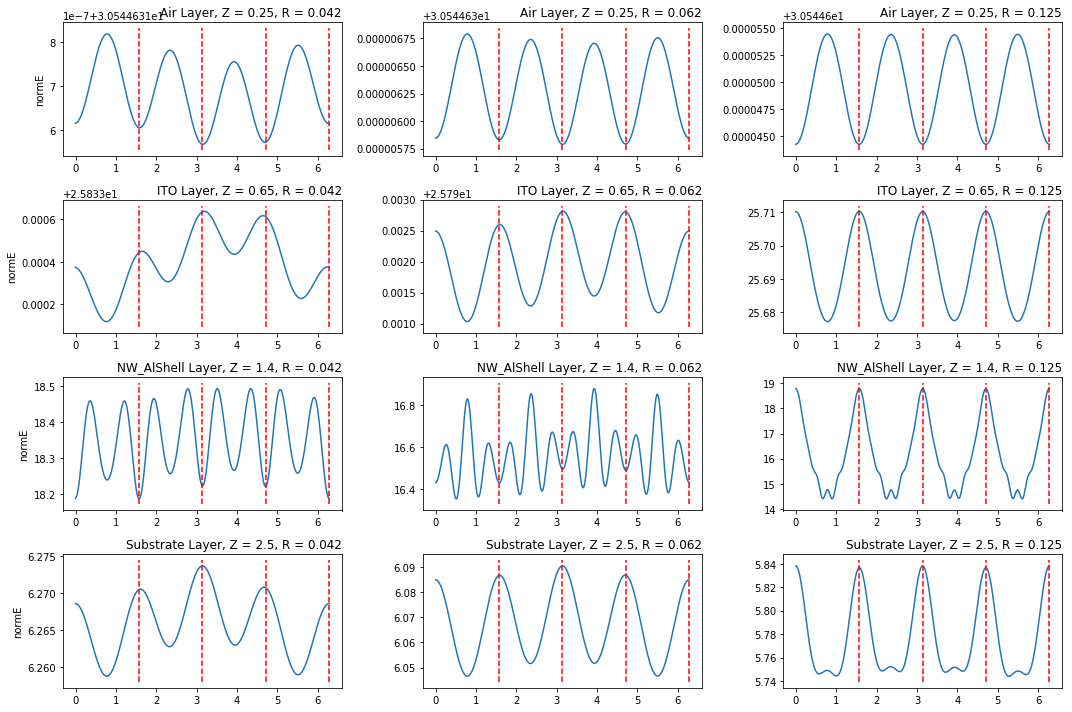

In [4]:
lines = [np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
fig, axes = plt.subplots(len(zvals), len(radii), figsize=(15, 10))
layer_counter = 0
for layer, results_list in results.items():
    for i, normE in enumerate(results_list):
        ax = axes[layer_counter, i]
        z = zvals[layer_counter][1]
        radius = radii[i]
        ax.plot(theta_vals, normE)
        ax.set_title('{} Layer, Z = {}, R = {:.3f}'.format(layer, z, radius), loc='right')
        if i == 0:
            ax.set_ylabel('normE')
        if layer_counter == len(zvals):
            ax.set_xlabel('Angle (Radians)')
        yvals = ax.get_ylim()
        for xval in lines:
            ax.plot([xval, xval], yvals, 'r--')
    layer_counter += 1
plt.tight_layout()
plt.show()

In [ ]:
Ok, so there is a lot going on here. First, there is very little variation in normE as a function of angle in the air layer,
as we could expect. This isn't obvious by just looking at the plot, you have to check the y axis values and the weird exponent
at the top of the y axis. The variation is in the 5th decimal place at most.

The variation is small in the ITO layer until we get out near the edge of the unit cell (the rightmost plot)

Some weird stuff is going on in the nanowire layer. Not sure what to make of the substrate either. 

In all cases, the 4-fold symmetry we could expect isn't super obviously present until R reaches the edge of the unit cell.
This is puzzling and somewhat concerning. To try to understand this a little better, I plot a 2D heatmap of normE in the x-y
plane for each of the z values shown above.

In [5]:
%%time
zvals = [('Air',.25), ('ITO', .65), ('NW_AlShell', 1.4), ('Substrate', 2.5)]
results = OrderedDict()
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    print('Computing in layer {} at z = {}'.format(layer, z))
    Ex, Ey, Ez = sim.compute_fields_on_plane(z, 150, 150)
    normE = np.sqrt(np.absolute(Ex)**2 + np.absolute(Ey)**2 + np.absolute(Ez)**2 )
    results[layer] = normE
print('Done!')

Computing in layer Air at z = 0.25
Computing in layer ITO at z = 0.65
Computing in layer NW_AlShell at z = 1.4
Computing in layer Substrate at z = 2.5
Done!
CPU times: user 176 ms, sys: 20 ms, total: 196 ms
Wall time: 195 ms


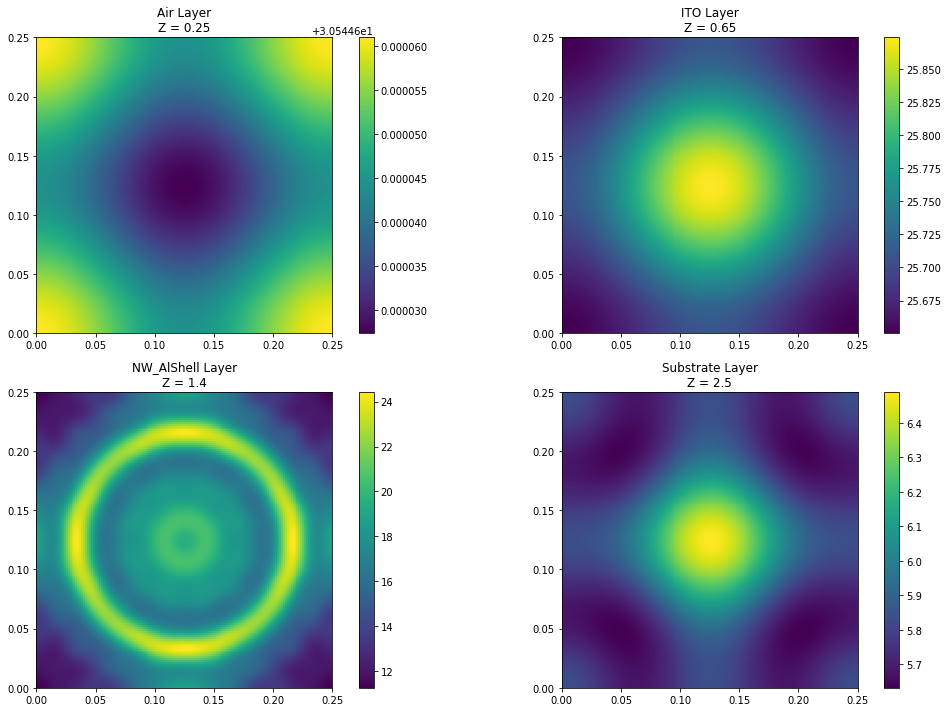

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
xmin = 0
xmax = sim.period
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    ax = axes[i]
    cax = ax.imshow(results[layer], extent=[xmin, xmax, xmin, xmax], aspect='equal')
    ax.set_title('{} Layer\nZ = {}'.format(layer, z))
    fig.colorbar(cax, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
So this is super weird and confusing. The nanowire clearly doesn't have fourfold rotational symmetry, none of the layers do for that matter.
Albeit the changes here are pretty small, but at least in the nanowire layer they are large enough to be concerning.

# Shifted Nanowire 400 Basis Terms

In [4]:
conf = Config('RotationalSymmetryTest.yml')
sim = Simulator(conf)
sim = setup_sim(sim)

In [5]:
Now I generate points on a circle within the simulation domain about the center of the nanowire. The origin of the coordinate system is _not_ 
at the center of the nanowire, which is why I shift the x and y values to the right and up by half the period. I do this for several values
of z, one in each layer of the device. For each z value, I also check the symmetry at several radii.

SyntaxError: invalid syntax (<ipython-input-5-eb431ef9d658>, line 1)

In [6]:
%%time
max_r = sim.period/2
radii = [max_r/3, max_r/2, max_r]
zvals = [('Air',.25), ('ITO', .65), ('NW_AlShell', 1.4), ('Substrate', 2.5)]
theta_samples = 360
theta_vals = np.linspace(0, 2*np.pi, theta_samples)
results = OrderedDict()
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    print('Computing in layer {} at z = {}'.format(layer, z))
    results[layer] = [None, None, None]
    for j, r in enumerate(radii):
        print('Computing at r = {}'.format(r))
        x = r*np.cos(theta_vals) + sim.period/2
        y = r*np.sin(theta_vals) + sim.period/2
        normE = np.zeros_like(x)
        for i in range(len(x)):
            Etup = sim.compute_fields_at_point(x[i], y[i], z)
            for comp in Etup:
                normE[i] += np.absolute(comp)**2
        normE = np.sqrt(normE)
        results[layer][j] = normE
print('Done!')

Computing in layer Air at z = 0.25
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer ITO at z = 0.65
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer NW_AlShell at z = 1.4
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer Substrate at z = 2.5
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Done!
CPU times: user 5min 16s, sys: 828 ms, total: 5min 17s
Wall time: 5min 16s


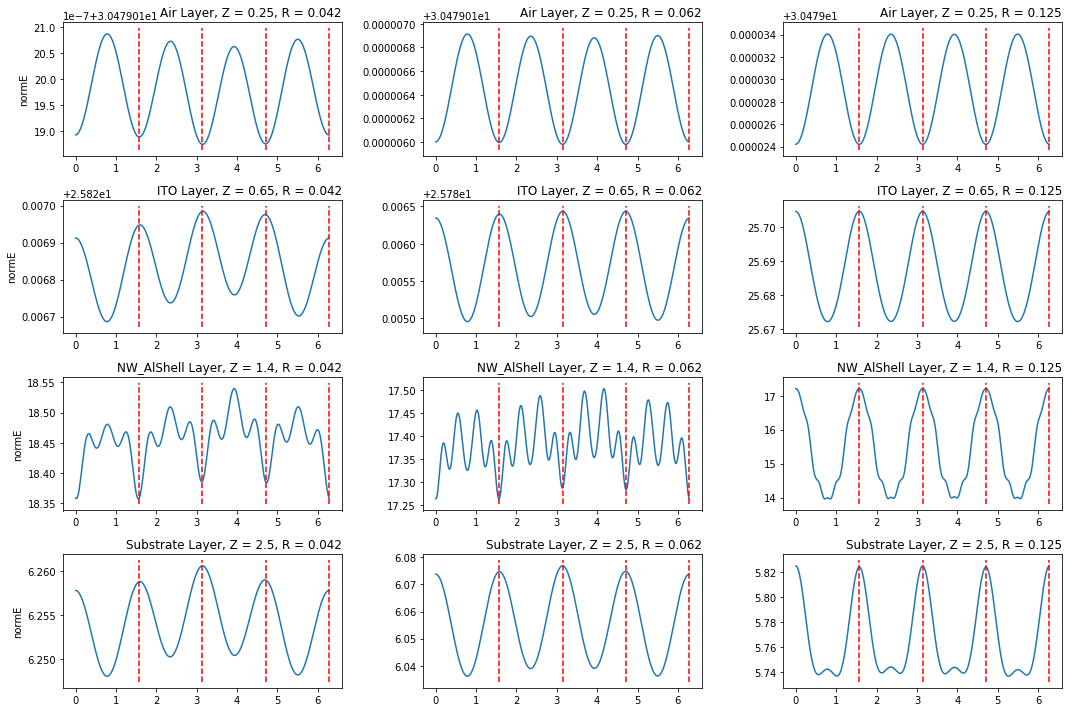

In [8]:
lines = [np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
fig, axes = plt.subplots(len(zvals), len(radii), figsize=(15, 10))
layer_counter = 0
for layer, results_list in results.items():
    for i, normE in enumerate(results_list):
        ax = axes[layer_counter, i]
        z = zvals[layer_counter][1]
        radius = radii[i]
        ax.plot(theta_vals, normE)
        ax.set_title('{} Layer, Z = {}, R = {:.3f}'.format(layer, z, radius), loc='right')
        if i == 0:
            ax.set_ylabel('normE')
        if layer_counter == len(zvals):
            ax.set_xlabel('Angle (Radians)')
        yvals = ax.get_ylim()
        for xval in lines:
            ax.plot([xval, xval], yvals, 'r--')
    layer_counter += 1
plt.tight_layout()
plt.show()

In [ ]:
Ok, so there is a lot going on here. First, there is very little variation in normE as a function of angle in the air layer,
as we could expect. This isn't obvious by just looking at the plot, you have to check the y axis values and the weird exponent
at the top of the y axis. The variation is in the 5th decimal place at most.

The variation is small in the ITO layer until we get out near the edge of the unit cell (the rightmost plot)

Some weird stuff is going on in the nanowire layer. Not sure what to make of the substrate either. 

In all cases, the 4-fold symmetry we could expect isn't super obviously present until R reaches the edge of the unit cell.
This is puzzling and somewhat concerning. To try to understand this a little better, I plot a 2D heatmap of normE in the x-y
plane for each of the z values shown above.

In [5]:
%%time
zvals = [('Air',.25), ('ITO', .65), ('NW_AlShell', 1.4), ('Substrate', 2.5)]
results = OrderedDict()
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    print('Computing in layer {} at z = {}'.format(layer, z))
    Ex, Ey, Ez = sim.compute_fields_on_plane(z, 150, 150)
    normE = np.sqrt(np.absolute(Ex)**2 + np.absolute(Ey)**2 + np.absolute(Ez)**2 )
    results[layer] = normE
print('Done!')

Computing in layer Air at z = 0.25
Computing in layer ITO at z = 0.65
Computing in layer NW_AlShell at z = 1.4
Computing in layer Substrate at z = 2.5
Done!
CPU times: user 176 ms, sys: 20 ms, total: 196 ms
Wall time: 195 ms


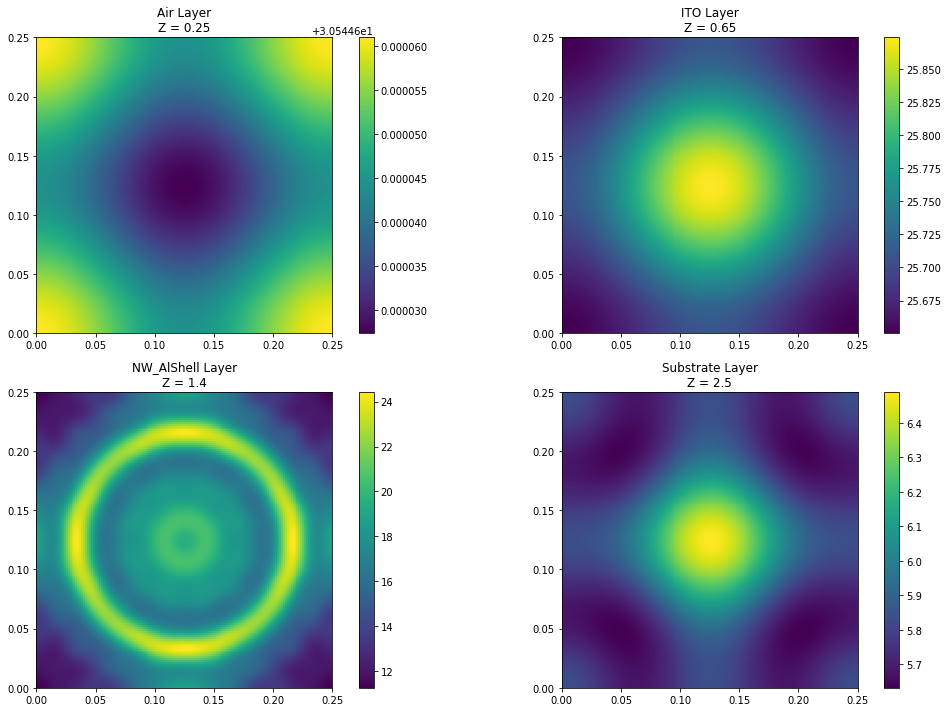

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
xmin = 0
xmax = sim.period
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    ax = axes[i]
    cax = ax.imshow(results[layer], extent=[xmin, xmax, xmin, xmax], aspect='equal')
    ax.set_title('{} Layer\nZ = {}'.format(layer, z))
    fig.colorbar(cax, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
So this is super weird and confusing. The nanowire clearly doesn't have fourfold rotational symmetry, none of the layers do for that matter.
Albeit the changes here are pretty small, but at least in the nanowire layer they are large enough to be concerning.

# Centered Nanowire

In [7]:
conf = Config('RotationalSymmetryTest_centered.yml')
sim = Simulator(conf)
sim = setup_sim(sim)

Here I don't shift the x and y values because the nanowire is not centered on the origin.

In [8]:
%%time
max_r = sim.period/2
radii = [max_r/3, max_r/2, max_r]
zvals = [('Air',.25), ('ITO', .65), ('NW_AlShell', 1.4), ('Substrate', 2.5)]
theta_samples = 360
theta_vals = np.linspace(0, 2*np.pi, theta_samples)
results = OrderedDict()
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    print('Computing in layer {} at z = {}'.format(layer, z))
    results[layer] = [None, None, None]
    for j, r in enumerate(radii):
        print('Computing at r = {}'.format(r))
        x = r*np.cos(theta_vals)
        y = r*np.sin(theta_vals)
        normE = np.zeros_like(x)
        for i in range(len(x)):
            Etup = sim.compute_fields_at_point(x[i], y[i], z)
            for comp in Etup:
                normE[i] += np.absolute(comp)**2
        normE = np.sqrt(normE)
        results[layer][j] = normE
print('Done!')

Computing in layer Air at z = 0.25
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer ITO at z = 0.65
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer NW_AlShell at z = 1.4
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Computing in layer Substrate at z = 2.5
Computing at r = 0.041666666666666664
Computing at r = 0.0625
Computing at r = 0.125
Done!
CPU times: user 48.3 s, sys: 136 ms, total: 48.4 s
Wall time: 48.1 s


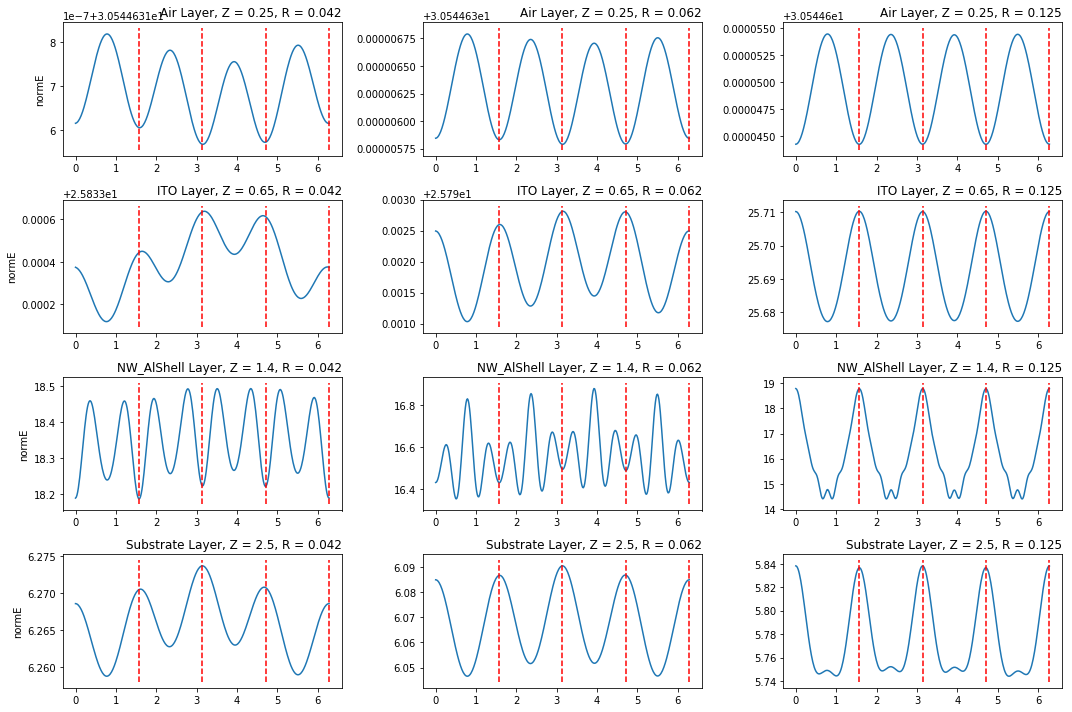

In [9]:
lines = [np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
fig, axes = plt.subplots(len(zvals), len(radii), figsize=(15, 10))
layer_counter = 0
for layer, results_list in results.items():
    for i, normE in enumerate(results_list):
        ax = axes[layer_counter, i]
        z = zvals[layer_counter][1]
        radius = radii[i]
        ax.plot(theta_vals, normE)
        ax.set_title('{} Layer, Z = {}, R = {:.3f}'.format(layer, z, radius), loc='right')
        if i == 0:
            ax.set_ylabel('normE')
        if layer_counter == len(zvals):
            ax.set_xlabel('Angle (Radians)')
        yvals = ax.get_ylim()
        for xval in lines:
            ax.plot([xval, xval], yvals, 'r--')
    layer_counter += 1
plt.tight_layout()
plt.show()

In [10]:
%%time
zvals = [('Air',.25), ('ITO', .65), ('NW_AlShell', 1.4), ('Substrate', 2.5)]
results = OrderedDict()
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    print('Computing in layer {} at z = {}'.format(layer, z))
    Ex, Ey, Ez = sim.compute_fields_on_plane(z, 150, 150)
    normE = np.sqrt(np.absolute(Ex)**2 + np.absolute(Ey)**2 + np.absolute(Ez)**2 )
    results[layer] = normE
print('Done!')

Computing in layer Air at z = 0.25
Computing in layer ITO at z = 0.65
Computing in layer NW_AlShell at z = 1.4
Computing in layer Substrate at z = 2.5
Done!
CPU times: user 132 ms, sys: 36 ms, total: 168 ms
Wall time: 128 ms


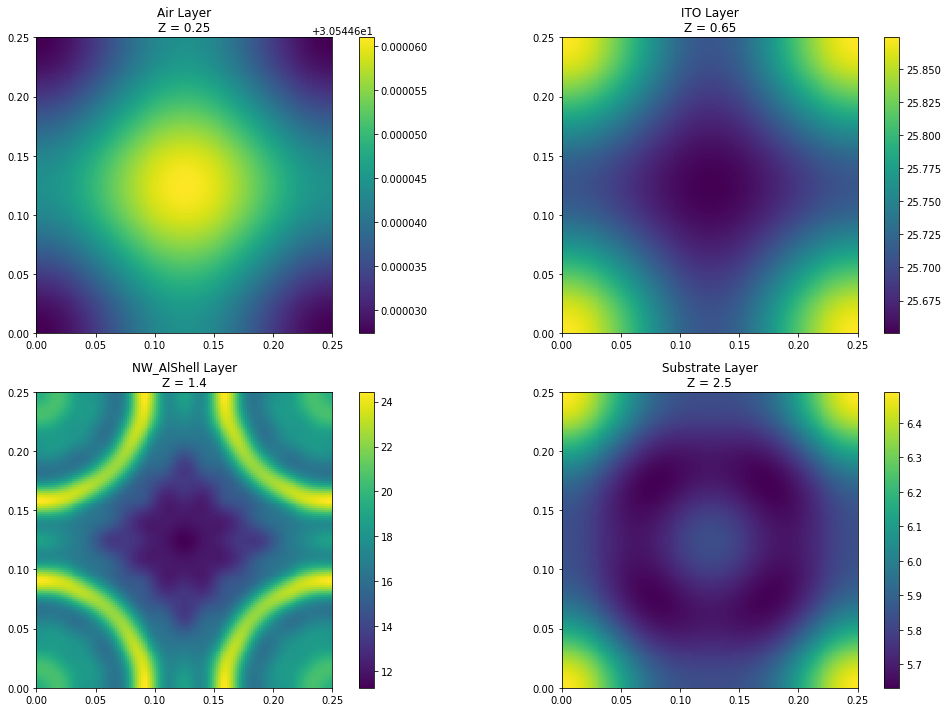

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
xmin = 0
xmax = sim.period
for i, ztup in enumerate(zvals):
    layer = ztup[0]
    z = ztup[1]
    ax = axes[i]
    cax = ax.imshow(results[layer], extent=[xmin, xmax, xmin, xmax], aspect='equal')
    ax.set_title('{} Layer\nZ = {}'.format(layer, z))
    fig.colorbar(cax, ax=ax)
plt.tight_layout()
plt.show()

# Conclusion

So the fields are definitely _NOT_ 4-fold symmetric. This is unexpected and concerning. The only good news here is that the results do not
depend on where we choose to put the nanowire (i.e choice of unit cell). I will need to consult Jacob about this.